# Alanine Dipeptide Experiments

This notebook contains experiments on the alanine dipeptide example. 

10 ns trajectories at 300, 400 and 500 K are available as input. The value of the coordinates and the $\phi$ and $\psi$ angles were saved every 1 ps. Thus we have $10^4$ frames for each trajectory and the same number of samples for the $\phi$ and $\psi$ torsion angles.

The typical free energy surface of alanine dipeptide is shown below.

<center><img src="../../../deep_cartograph/data/alanine_dipeptide/aldip.png" width="800"/></center>

In this system there are two main transitions.

- Transitions between C5 and C7eq (fast transition)
- Transition between C7eq or C5 and C7ax (slow transition)

Plotting the time series we can see how slow is each transition:

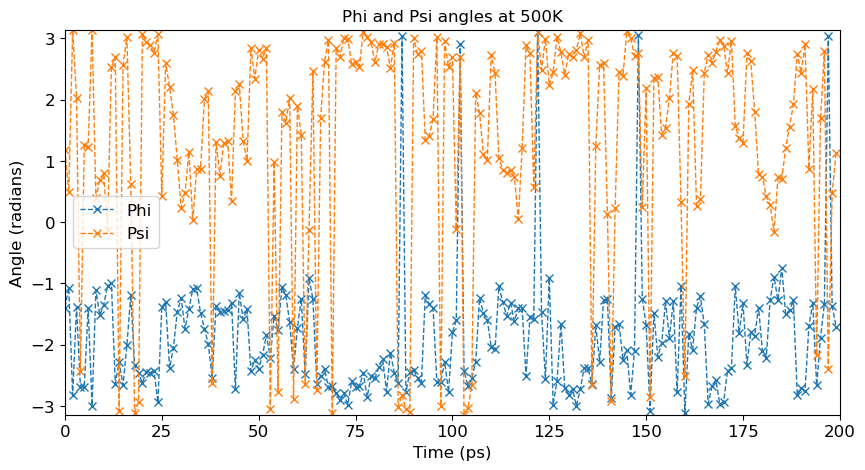

In [10]:
from deep_cartograph.modules.plumed.colvars import read_colvars
import importlib.resources as resources
from deep_cartograph import data

import matplotlib.pyplot as plt
import math

# Get the path to the data
data_folder = resources.files(data)

temperature = 500 # K
max_time = 200    # ps
font_size = 12

models = ['pca', 'ae', 'vae', 'tica', 'deep_tica']

# Find csv with projected trajectory onto phi psi
phi_psi_path = f"{data_folder}/alanine_dipeptide/input/{temperature}K/phi_psi.dat"

# Read the data
phi_psi = read_colvars(phi_psi_path)

# Convert time from ns to ps
phi_psi['time'] = phi_psi['time'] * 1000

# Sample just the first 200 ps for the plot
phi_psi = phi_psi[phi_psi['time'] < max_time]

# Plot time series of phi and psi
plt.figure(figsize=(10, 5))

# Plot phi and psi without lines and with different colors
plt.plot(phi_psi['time'], phi_psi['phi'], label='Phi', linestyle='--', marker='x', linewidth=1)
plt.plot(phi_psi['time'], phi_psi['psi'], label='Psi', linestyle='--', marker='x', linewidth=1)

plt.xlim(0, max_time)
plt.ylim(-math.pi, math.pi)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.xlabel('Time (ps)', fontsize=font_size)
plt.ylabel('Angle (radians)', fontsize=font_size)

plt.legend(fontsize=font_size)

plt.title(f'Phi and Psi angles at {temperature}K', fontsize=font_size)

plt.show()

Clearly $\phi$ encodes the slowest transition to and from C7ax.

In [11]:
from deep_cartograph.deep_carto import deep_cartograph
from IPython.display import display, HTML
from typing import Literal, Dict
from decimal import Decimal
import pandas as pd
import logging
import shutil
import yaml
import time
import os


# Set logging level
logging.basicConfig(level=logging.INFO)

font_size = 12

def run_deep_cartograph(configuration: Dict, features: Literal['torsions', 'distances'], temperature: int, test_name: str = None, 
                        traj_path: str = None, topology_path: str = None): 
    """
    Runs deep cartograph using one of the alanine dipeptide trajectories at a certain temperature. Using one of the feature dictionaries
    and the provided configuration.

    Input
    -----

        configuration: configuration for all the steps of the deep cartograph main workflow
        features:      choice of features to use to train/compute the CVs
        temperature:   temperature of the alanine dipeptide simulations to use
        test_name:     name of the test that will be used as output folder name
        traj_path:     path to the trajectory file
        topology_path: path to the topology file
    """

    # Input paths
    input_path = f"{data_folder}/alanine_dipeptide/input/"

    if not traj_path:
        traj_folder = os.path.join(input_path, f"{temperature}K")
        traj_path = os.path.join(traj_folder, "trajectory.xtc")
    
    if not topology_path:
        top_path = os.path.join(input_path, 'topology.pdb')
        
    # Output folder
    output_folder = f"{data_folder}/alanine_dipeptide/output/{temperature}K/{features}"

    if test_name:
        output_folder = os.path.join(output_folder, test_name)

    # Clean output folder
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)

    # Run workflow 
    deep_cartograph(
        configuration = configuration,
        trajectory_data = traj_path,
        topology_data = top_path,
        output_folder = output_folder)

def show_results(features: Literal['torsions', 'distances'], temperature: int, model_name: str, test_name: str = None,
                 phi_psi_path: str = None):
    """
    Show the most important results for a specific model trained with deep cartograph

    Input
    -----

        features:     choice of input features used
        temperature:  temperature of the alanine dipeptide simulations used
        model_name:   type of cv to analyze (pca, ae, tica or deep_tica)
        test_name:    name of the test that was used for the output folder
    """

    def get_alpha(size):
        """
        Compute alpha value for the scatter plot

        Input
        -----

            size: size of the dataset

        Output
        ------

            alpha: alpha value
        """

        if size > 5000:
            alpha = 0.3
        elif size > 1000:
            alpha = 0.5
        elif size > 500:
            alpha = 0.7
        else:
            alpha = 1.0

        return alpha
    
    def show_score(score_path):
        """
        Print score path in a nice format 

        Input
        -----

            score_path: path to the score file
        """

        # Read score
        with open(score_path, 'r') as file:
            score = file.read()

        # Print score in scientific notation
        print(f"Final model score: {Decimal(score):.4E}")

    def show_eigenvalues(eig_path):
        """
        Print eigenvalues in a nice format

        Input
        -----

            eig_path: path to the eigenvalues file
        """

        # Read eigenvalues
        with open(eig_path, 'r') as file:
            eigenvalues = file.readlines()

        # Print eigenvalues
        for i, eig in enumerate(eigenvalues):
            print(f"Eigenvalue {i+1}: {Decimal(eig):.4E}")
            
    def ramachandran_projection(phi_psi_path: str, cv_path: str):   
        """
        Project the phi, psi samples coloring them by the CV values

        Input
        -----

            phi_psi_path: path to plumed colvars file with phi, psi data along trajectory
            cv_path:      path to csv file with cv data along trajectory
        """

        import matplotlib.pyplot as plt
        from pathlib import Path

        # Read phi psi data as pandas dataframe
        phi_psi_df = read_colvars(phi_psi_path)

        # Find size of dataframe
        size = phi_psi_df.shape[0]

        # Drop "time" column
        phi_psi_df = phi_psi_df.drop(columns = ['time'])

        # Read CV csv as pandas dataframe
        cv_df = pd.read_csv(cv_path)

        # Find model path
        model_path = Path(cv_path).parent

        # Drop "cluster" column if present
        if 'cluster' in cv_df.columns:
            cv_df = cv_df.drop(columns = ['cluster'])

        # Find the rest of the columns / CV components
        components = cv_df.columns

        images_html = []

        # Check if both dataframes have the same number of samples
        delta_samples = phi_psi_df['phi'].shape[0] - cv_df[components[0]].shape[0]

        # If not, the CV is a Deep TICA model with a lag time different from 0, discard the last delta_samples from the phi, psi data
        if delta_samples > 0:
            phi_psi_df = phi_psi_df.iloc[:-delta_samples]

        # For each CV column in the cv_df
        for component in components:
            
            plt.figure()  

            # Add limits to the plot (-pi, pi)
            plt.xlim(-math.pi, math.pi)
            plt.ylim(-math.pi, math.pi)
            
            # Create scatter plot
            scatter = plt.scatter(phi_psi_df['phi'], phi_psi_df['psi'], c=cv_df[component], s=8, alpha=get_alpha(size))

            # Set labels and title
            plt.xlabel('Phi', fontsize=font_size)
            plt.ylabel('Psi', fontsize=font_size)
            plt.title(f'{component} projection onto Ramachandran space', fontsize=font_size)
            
            # Increase tick size
            plt.xticks(fontsize=font_size)
            plt.yticks(fontsize=font_size)

            # Add colorbar
            cbar = plt.colorbar(scatter)
            cbar.set_label(component, fontsize=font_size)
            cbar.ax.tick_params(labelsize=font_size)
                
            # Set alpha for the colorbar by modifying the colormap
            cbar.solids.set_alpha(1.0)  

            # Create path for figure
            figure_path = os.path.join(model_path, f'{component}_ramachandran.png')

            # Generate HTML image tag and append to list
            timestamp = int(time.time()) # Add timestamp to avoid caching
            images_html.append(f'<img src="{figure_path}?{timestamp}" style="width: 600px; margin-right: 10px;">')

            # Save figure 
            plt.savefig(figure_path)

            # Close figure
            plt.close()

        # Display images
        display(HTML(''.join(images_html)))

    # Output_folder
    output_folder = f"{data_folder}/alanine_dipeptide/output/{temperature}K/{features}"

    if test_name:
        output_folder = os.path.join(output_folder, test_name)

    # Show output folder
    print(f"Output folder: {output_folder}")

    # Find csv with projected trajectory onto phi psi
    if not phi_psi_path:
        phi_psi_path = f"{data_folder}/alanine_dipeptide/input/{temperature}K/phi_psi.dat"

    # Show phi psi path
    print(f"Phi psi path: {phi_psi_path}")

    # Find model path
    model_path = os.path.join(output_folder, "train_colvars", model_name)

    # Find csv with projected trajectory onto CV
    cv_path = os.path.join(model_path, "traj_data", "trajectory", "projected_trajectory.csv")

    # Find score if any
    if model_name in models:
        score_path = os.path.join(model_path, "training", "model_score.txt")
        if os.path.exists(score_path):
            show_score(score_path)
        else:
            print("Score file not found")

    # Find eigenvalues if any
    if model_name == 'deep_tica':
        eig_path = os.path.join(model_path, "training", "eigenvalues.txt")
        if os.path.exists(eig_path):
            show_eigenvalues(eig_path)
        else:
            print("Eigenvalues file not found")

    # Project CV onto Ramachandran space
    ramachandran_projection(phi_psi_path, cv_path)

    # Paths to images
    loss = os.path.join(model_path, 'loss.png')
    eigenvalues = os.path.join(model_path, 'eigenvalues.png')
    paths = [loss, eigenvalues]

    # Generate HTML image tags
    timestamp = int(time.time()) # Add timestamp to avoid caching
    images_html = [f'<img src="{path}?{timestamp}" style="width: 600px; margin-right: 10px;">' for path in paths if os.path.exists(path)]

    # Display images
    display(HTML(''.join(images_html)))

## Using torsion angles

Let's see if the autoencoder and the deep-tica models are able to identify the slow modes in the trajectory. 

Here we use real torsion angles between heavy atoms as input features, see the 'dihedral_group' definition in the input YAML. It should be relatively easy for the models to identify the slow torsion angles $\phi$ and $\psi$.

### Testing batch size

Train the Autoencoder or the Deep TICA model with different batch sizes.

In general, we know that smaller batch sizes can introduce more noise in the gradient updates, which can help the model scape local or sharp minima and find better solutions. Thus generalize better (see relation between training and validation loss). Smaller batch sizes can also slow down the training process but in this case we are using small models and small datasets so it should not be a problem.

In [12]:
# Choose the features to work with (torsions or distances)
features = 'torsions'

# Choose temperature of the simulations (300 K shows just one transition, 400 K starts to show two, 500 K clearly shows two transitions)
temperature = 500

# Load initial configuration
config_path = f"{data_folder}/alanine_dipeptide/input/{features}_config.yml"

with open(config_path, 'r') as file:
    configuration = yaml.load(file, Loader = yaml.FullLoader)

# Select model
configuration['train_colvars']['cvs'] = models

# Select batch sizes - Alanine trajs have a total of 10000 samples
batch_sizes = [128, 2048]

for batch_size in batch_sizes:

    # Name of the test
    test_name = f'bs_{batch_size}'

    # Make a copy of the initial configuration
    test_configuration = configuration.copy()

    # Update batch size
    test_configuration['train_colvars']['common']['training']['general']['batch_size'] = batch_size

    # Run deep cartograph
    run_deep_cartograph(test_configuration, features, temperature, test_name)

INFO:deep_cartograph:================
INFO:deep_cartograph:Analyze geometry
INFO:deep_cartograph:================
INFO:deep_cartograph:Elapsed time (Analyze geometry): 00 h 00 min 00 s
INFO:deep_cartograph:================
INFO:deep_cartograph:Compute features
INFO:deep_cartograph:================
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
INFO:MDAnalysis.core.universe:attribute types has been guessed successfully.
INFO:MDAnalysis.core.universe:attribute masses has been guessed successfully.
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'elements' Using d

INFO:deep_cartograph.modules.plumed.cli:Restored working directory to: /home/pnavarro/repos/mlcolvar
INFO:deep_cartograph:Elapsed time (Compute features): 00 h 00 min 01 s
INFO:deep_cartograph:==================
INFO:deep_cartograph:Filtering features
INFO:deep_cartograph:==================
INFO:deep_cartograph:Finding the features that contains the most information about the transitions or conformational changes.
INFO:deep_cartograph:The following algorithms are available:
INFO:deep_cartograph:- Hartigan's dip test filter. Keeps features that are not unimodal.
INFO:deep_cartograph:- Shannon entropy filter. Keeps features with entropy greater than a threshold.
INFO:deep_cartograph:- Standard deviation filter. Keeps features with standard deviation greater than a threshold.
INFO:deep_cartograph:Note that the all features must be in the same units to apply the entropy and standard deviation filters meaningfully.
INFO:deep_cartograph.modules.features.filter:Initializing Filter
INFO:deep_c

KEY:  data




INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Processing trajectory: trajectory
INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Corresponding colvars file: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/bs_128/compute_features/trajectory/colvars.dat
INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Corresponding topology file: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/topology.pdb
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
INFO:MDAnalysis.core.universe:attribute types has been guessed successfully.
I

KLAAnnealing initialized with type=cyclical, start_beta=0.0, max_beta=0.01)


INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:deep_cartograph.modules.cv_learning.cv_calculator:Successfully loaded the 'last' model from: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/bs_128/train_colvars/vae/training/checkpoints/last.ckpt
INFO:deep_cartograph.modules.cv_learning.cv_calculator:  -> Best Overall Score:      0.00549
INFO:deep_cartograph.modules.cv_learning.cv_calculator:  -> Best Post-Annealing Score: inf
INFO:deep_cartograph.modules.cv_learning.cv_calculator:  -> Last Model Score:          0.00549
INFO:deep_cartograph.modules.common.common:Starting compression to '/home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/bs_128/train_colvars/vae/training/training_metrics.zip'...
INFO:deep_cartograph.modules.common.common:Successfully created zip file: '

KEY:  data




INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Processing trajectory: trajectory
INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Corresponding colvars file: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/bs_128/compute_features/trajectory/colvars.dat
INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Corresponding topology file: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/topology.pdb
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
INFO:MDAnalysis.core.universe:attribute types has been guessed successfully.
I

KEY:  data


KEY:  data_lag


KEY:  weights


KEY:  weights_lag




INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Processing trajectory: trajectory
INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Corresponding colvars file: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/bs_128/compute_features/trajectory/colvars.dat
INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Corresponding topology file: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/topology.pdb
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
INFO:MDAnalysis.core.universe:attribute types has been guessed successfully.
I

KEY:  data




INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Processing trajectory: trajectory
INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Corresponding colvars file: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/bs_2048/compute_features/trajectory/colvars.dat
INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Corresponding topology file: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/topology.pdb
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
INFO:MDAnalysis.core.universe:attribute types has been guessed successfully.


KLAAnnealing initialized with type=cyclical, start_beta=0.0, max_beta=0.01)


INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:deep_cartograph.modules.cv_learning.cv_calculator:Successfully loaded the 'last' model from: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/bs_2048/train_colvars/vae/training/checkpoints/last.ckpt
INFO:deep_cartograph.modules.cv_learning.cv_calculator:  -> Best Overall Score:      0.02323
INFO:deep_cartograph.modules.cv_learning.cv_calculator:  -> Best Post-Annealing Score: inf
INFO:deep_cartograph.modules.cv_learning.cv_calculator:  -> Last Model Score:          0.02330
INFO:deep_cartograph.modules.common.common:Starting compression to '/home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/bs_2048/train_colvars/vae/training/training_metrics.zip'...
INFO:deep_cartograph.modules.common.common:Successfully created zip file:

KEY:  data




INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Processing trajectory: trajectory
INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Corresponding colvars file: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/bs_2048/compute_features/trajectory/colvars.dat
INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Corresponding topology file: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/topology.pdb
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
INFO:MDAnalysis.core.universe:attribute types has been guessed successfully.


KEY:  data


KEY:  data_lag


KEY:  weights


KEY:  weights_lag




INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Processing trajectory: trajectory
INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Corresponding colvars file: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/bs_2048/compute_features/trajectory/colvars.dat
INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Corresponding topology file: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/topology.pdb
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
INFO:MDAnalysis.core.universe:attribute types has been guessed successfully.


<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

### Testing batch size


In [13]:
# Show results for the Autoencoder, Variational Autoencoder and Deep TICA models with different batch sizes
for model in ['ae', 'vae', 'deep_tica']:
    
    print(f"Model: {model} ########################################################### #")
    
    for batch_size in batch_sizes:

        print(f"Batch size: {batch_size} ----------------------------------------------- #")

        # Test name
        test_name = f'bs_{batch_size}'

        # Show main results
        show_results(features, temperature, model, test_name)

Model: ae ########################################################### #
Batch size: 128 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/bs_128
Phi psi path: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/500K/phi_psi.dat
Final model score: 5.6366E-3


Batch size: 2048 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/bs_2048
Phi psi path: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/500K/phi_psi.dat
Final model score: 2.5956E-2


Model: vae ########################################################### #
Batch size: 128 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/bs_128
Phi psi path: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/500K/phi_psi.dat
Final model score: 5.4910E-3


Batch size: 2048 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/bs_2048
Phi psi path: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/500K/phi_psi.dat
Final model score: 2.3298E-2


Model: deep_tica ########################################################### #
Batch size: 128 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/bs_128
Phi psi path: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/500K/phi_psi.dat
Final model score: -9.4364E-1
Eigenvalue 1: 9.7017E-1


Batch size: 2048 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/bs_2048
Phi psi path: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/500K/phi_psi.dat
Final model score: -9.6240E-1
Eigenvalue 1: 9.8102E-1


In [14]:
# Show results for the pca and htica models
for model in ['pca', 'tica']:
    
    print(f"Model: {model} ########################################################### #")
    
    for batch_size in batch_sizes:

        print(f"Batch size: {batch_size} ----------------------------------------------- #")

        # Test name
        test_name = f'bs_{batch_size}'

        # Show main results
        show_results(features, temperature, model, test_name)

Model: pca ########################################################### #
Batch size: 128 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/bs_128
Phi psi path: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/500K/phi_psi.dat
Score file not found


Batch size: 2048 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/bs_2048
Phi psi path: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/500K/phi_psi.dat
Score file not found


Model: tica ########################################################### #
Batch size: 128 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/bs_128
Phi psi path: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/500K/phi_psi.dat
Score file not found


Batch size: 2048 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/bs_2048
Phi psi path: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/500K/phi_psi.dat
Score file not found


- Trainings with smaller batch sizes reach lower validation losses in fewer epochs and better models! 
- Models trained with smaller batch size show latent space variables that encode different slow modes of the system and better generalization capabilities (see difference between training and validation losses).

In this case the computational cost of each epoch is not a concern, so the recommendation is to use a small batch size for the autoencoder (64-256 or 0.5 - 3 % of the training data). 

- Latent space of models trained with lower batch sizes capture better the slow modes (128-256 samples or 1-3 % of the dataset size). 

Here we can see that a lower loss doesn't always correspond to a better model. The lower batch size models are able to capture both
slow modes, while the higher batch size models only capture the slowest mode.

Both models are able to learn the main slow mode of the system from the torsion angles. However the Autoencoder yields a smooth CV that captures all slow transitions while the Deep TICA model only captures the main slow mode.

- In general, the training of the Deep TICA model is more delicate than the Autoencoder. There are more hyper-parameters involved.

Note that these results are also dependent on other hyper-parameters and the dataset itself.

### Testing different lag times (Deep TICA)

In [ ]:
# Choose the features to work with (torsions or distances)
features = 'torsions'

# Choose temperature of the simulations (300 K shows just one transition, 400 K starts to show two, 500 K clearly shows two transitions)
temperature = 500

# Load initial configuration
config_path = f"{data_folder}/alanine_dipeptide/input/{features}_config.yml"

with open(config_path, 'r') as file:
    configuration = yaml.load(file, Loader = yaml.FullLoader)

# Select model
configuration['train_colvars']['cvs'] = ['deep_tica']

# Select batch size
batch_size = 256

# Select lag times to test (in number of samples)
# The delta t between samples is 1 ps, thus the lag time is in ps in this case
lag_times = [1, 10, 50, 200]

for lag_time in lag_times:

    # Name of the test
    test_name = f'lag_{lag_time}_1D'

    # Make a copy of the initial configuration
    test_configuration = configuration.copy()

    # Update configuration
    test_configuration['train_colvars']['common']['training']['general']['batch_size'] = batch_size
    test_configuration['train_colvars']['common']['dimension'] = 1
    test_configuration['train_colvars']['common']['lag_time'] = lag_time

    # Run deep cartograph
    run_deep_cartograph(test_configuration, features, temperature, test_name)

INFO:deep_cartograph:================
INFO:deep_cartograph:Analyze geometry
INFO:deep_cartograph:================


INFO:deep_cartograph:Elapsed time (Analyze geometry): 00 h 00 min 00 s
INFO:deep_cartograph:================
INFO:deep_cartograph:Compute features
INFO:deep_cartograph:================
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
INFO:MDAnalysis.core.universe:attribute types has been guessed successfully.
INFO:MDAnalysis.core.universe:attribute masses has been guessed successfully.
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'elements' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/pnavarro/.conda/envs/deep_cartogra

KEY:  data


KEY:  data_lag


KEY:  weights


KEY:  weights_lag




INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Processing trajectory: trajectory
INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Corresponding colvars file: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/lag_1_1D/compute_features/trajectory/colvars.dat
INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Corresponding topology file: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/topology.pdb
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
INFO:MDAnalysis.core.universe:attribute types has been guessed successfully.

KEY:  data


KEY:  data_lag


KEY:  weights


KEY:  weights_lag




INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Processing trajectory: trajectory
INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Corresponding colvars file: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/lag_10_1D/compute_features/trajectory/colvars.dat
INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Corresponding topology file: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/topology.pdb
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
INFO:MDAnalysis.core.universe:attribute types has been guessed successfully

KEY:  data


KEY:  data_lag


KEY:  weights


KEY:  weights_lag




INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Processing trajectory: trajectory
INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Corresponding colvars file: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/lag_50_1D/compute_features/trajectory/colvars.dat
INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Corresponding topology file: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/topology.pdb
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
INFO:MDAnalysis.core.universe:attribute types has been guessed successfully

KEY:  data


KEY:  data_lag


KEY:  weights


KEY:  weights_lag




INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Processing trajectory: trajectory
INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Corresponding colvars file: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/lag_200_1D/compute_features/trajectory/colvars.dat
INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Corresponding topology file: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/topology.pdb
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
INFO:MDAnalysis.core.universe:attribute types has been guessed successfull

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

In [16]:
# Show results for the Deep TICA model

for lag_time in lag_times:

    print(f"Lag time: {lag_time} ----------------------------------------------- #")

    # Name of the test
    test_name = f'lag_{lag_time}_1D'

    # Show main results
    show_results(features, temperature, 'deep_tica', test_name)

Lag time: 1 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/lag_1_1D
Phi psi path: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/500K/phi_psi.dat
Final model score: -9.5487E-1
Eigenvalue 1: 9.7676E-1


Lag time: 10 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/lag_10_1D
Phi psi path: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/500K/phi_psi.dat
Final model score: -6.6881E-1
Eigenvalue 1: 8.0942E-1


Lag time: 50 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/lag_50_1D
Phi psi path: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/500K/phi_psi.dat
Final model score: -9.2748E-2
Eigenvalue 1: 2.9043E-1


Lag time: 200 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/torsions/lag_200_1D
Phi psi path: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/500K/phi_psi.dat
Final model score: -4.9800E-4
Eigenvalue 1: -8.8297E-3


We see here that:

- Small lag time (1 ps) captures all slow transitions with a stable training.
- Large lag times (> 100 ps) only capture the main slow mode and yield unstable trainings.

Until now we where working with torsion features. In this case, two of the torsion angles are enough to describe the slow modes of the system ($\phi$ and $\psi$). Thus the relationship between the input features and the slow modes is trivial. In the following section we use distances between heavy atoms as a less trivial input feature set.

### Testing distances

Here we use distances between heavy atoms as input features. The relationship between the input features and the slow modes now is less trivial.

In [17]:
# Choose the features to work with (torsions or distances)
features = 'distances'

# Load initial configuration
config_path = f"{data_folder}/alanine_dipeptide/input/{features}_config.yml"

with open(config_path, 'r') as file:
    configuration = yaml.load(file, Loader = yaml.FullLoader)

# Select model
configuration['train_colvars']['cvs'] = models

for batch_size in batch_sizes:

    # Name of the test
    test_name = f'bs_{batch_size}'

    # Make a copy of the initial configuration
    test_configuration = configuration.copy()

    # Update batch size
    test_configuration['train_colvars']['common']['training']['general']['batch_size'] = batch_size

    # Run deep cartograph
    run_deep_cartograph(test_configuration, features, temperature, test_name)

INFO:deep_cartograph:================
INFO:deep_cartograph:Analyze geometry
INFO:deep_cartograph:================
INFO:deep_cartograph:Elapsed time (Analyze geometry): 00 h 00 min 00 s
INFO:deep_cartograph:================
INFO:deep_cartograph:Compute features
INFO:deep_cartograph:================
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
INFO:MDAnalysis.core.universe:attribute types has been guessed successfully.
INFO:MDAnalysis.core.universe:attribute masses has been guessed successfully.


/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'elements' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
INFO:MDAnalysis.core.universe:attribute types has been guessed successfully.
INFO:MDAnalysis.core.universe:attribute masses has been guessed successfully.
INFO:MDAnalysis.core.universe:attribute types has been guessed successfully.
INFO:MDAnalysis.core.universe:attribute masses has been guessed successfully.
INFO:deep_cartograph:Computing features for trajectory with topology topology...
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWa

KEY:  data


KEY:  data_lag


KEY:  weights


KEY:  weights_lag




INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Processing trajectory: trajectory
INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Corresponding colvars file: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/distances/bs_128/compute_features/trajectory/colvars.dat
INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Corresponding topology file: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/topology.pdb
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
INFO:MDAnalysis.core.universe:attribute types has been guessed successfully.


KEY:  data


KEY:  data_lag


KEY:  weights


KEY:  weights_lag




INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Processing trajectory: trajectory
INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Corresponding colvars file: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/distances/bs_2048/compute_features/trajectory/colvars.dat
INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Corresponding topology file: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/topology.pdb
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
INFO:MDAnalysis.core.universe:attribute types has been guessed successfully.

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

### Testing batch size

In [19]:
# Show results for the Autoencoder, Variational Autoencoder and Deep TICA models with different batch sizes
for model in ['ae', 'vae', 'deep_tica']:
    
    print(f"Model: {model} ########################################################### #")
    
    for batch_size in batch_sizes:

        print(f"Batch size: {batch_size} ----------------------------------------------- #")

        # Test name
        test_name = f'bs_{batch_size}'

        # Show main results
        show_results(features, temperature, model, test_name)

Model: ae ########################################################### #
Batch size: 128 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/distances/bs_128
Phi psi path: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/500K/phi_psi.dat


FileNotFoundError: [Errno 2] No such file or directory: '/home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/distances/bs_128/train_colvars/ae/traj_data/trajectory/projected_trajectory.csv'

- The Autoencoder captures just the second slowest transition (the most frequent one) but not the slowest one, this behavior seems independent of the batch size. 

The autoencoder is discarding the slowest transition because it is not very well represented in the data.

- The Deep TICA model is able to capture all slow transitions from the data. 

We can see that when the relationship between the features and the slow modes is not trivial and one of the metastable states is underrepresented in the data, the Deep TICA model better at capturing the slow modes compared to the Autoencoder.

### Training with very rare transitions

The trajectory at 400 K shows contains less transitions between C5/C7eq and C7ax conformations. We can use this trajectory to further test the performance of the models when trained with very rare transitions. 

When using distances we saw that the Autoencoder was not able to capture the slowest transition which was underrepresented in the data. Using torsion angles though, the relation between the input features and the slow modes is trivial and the Autoencoder was able to capture the slowest transition. Let's see if this is still the case when the slowest transition is even more underrepresented in the data by switching to the 400 K trajectory.

In [ ]:
# Choose the features to work with (torsions or distances)
features = 'torsions'

# Choose temperature of the simulations (300 K shows just one transition, 400 K starts to show two, 500 K clearly shows two transitions)
temperature = 400

# Load initial configuration
config_path = f"{data_folder}/alanine_dipeptide/input/{features}_config.yml"

with open(config_path, 'r') as file:
    configuration = yaml.load(file, Loader = yaml.FullLoader)

# Select model
configuration['train_colvars']['cvs'] = models

# Select batch size
batch_size = 128

# Name of the test
test_name = f'1D'

# Make a copy of the initial configuration
test_configuration = configuration.copy()

# Update configuration
test_configuration['train_colvars']['common']['training']['general']['batch_size'] = batch_size

# Run deep cartograph
run_deep_cartograph(test_configuration, features, temperature, test_name)

INFO:deep_cartograph:================
INFO:deep_cartograph:Compute features
INFO:deep_cartograph:================
INFO:deep_cartograph:Trajectory file: ../../data/alanine_dipeptide/input/400K/trajectory.xtc
/shared/work/pnavarro/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/shared/work/pnavarro/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning: Found no information for attr: 'elements' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
INFO:deep_cartograph.modules.md.md:Topology does not contain bonds. Bonds will be guessed using a distance criterion (bond_length < 2.0).
INFO:deep_cartograph.modules.plumed.input_file.input_file:Found 20 features f

INFO:deep_cartograph:Elapsed time (Compute features): 00 h 00 min 01 s
INFO:deep_cartograph:==================
INFO:deep_cartograph:Filtering features
INFO:deep_cartograph:==================
INFO:deep_cartograph:Finding the features that contains the most information about the transitions or conformational changes.
INFO:deep_cartograph:The following algorithms are available:
INFO:deep_cartograph:- Hartigan's dip test filter. Keeps features that are not unimodal.
INFO:deep_cartograph:- Shannon entropy filter. Keeps features with entropy greater than a threshold.
INFO:deep_cartograph:- Standard deviation filter. Keeps features with standard deviation greater than a threshold.
INFO:deep_cartograph:- Final Mutual information clustering (AMINO). Clusters filtered features according to a mutual information based distance and selects one feature per cluster minimizing the distorsion.
INFO:deep_cartograph:Note that the all features must be in the same units to apply the entropy and standard de

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

In [ ]:
# Show results for both

# Name of the test
test_name = f'1D'

# Show results for the Autoencoder, Variational Autoencoder and Deep TICA models with different batch sizes
for model in models:
    
    print(f"Model: {model} ########################################################### #")

    # Show main results
    show_results(features, temperature, model, test_name)

Autoencoder ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/distances/1D
Phi psi path: /home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/input/500K/phi_psi.dat
Score file not found


FileNotFoundError: [Errno 2] No such file or directory: '/home/pnavarro/repos/NBDsoftware/deep_cartograph/deep_cartograph/data/alanine_dipeptide/output/500K/distances/1D/train_colvars/ae/traj_data/trajectory/projected_trajectory.csv'

We can see how the Deep TICA model is able to capture the slowest transition even when it is underrepresented in the data while the Autoencoder is not able to do so even when using torsion angles as input features.

- When a metastable state is underrepresented in the data, the Deep TICA model will be able to identify the transition between the rare state and the rest more easily than the Autoencoder.

### Training with scarce data

What happens if we try to train the models with fewer and fewer data points? How small a trajectory can be to learn the slow modes effectively from it?

Let's compare the performance of the models when trained with 10000, 5000, 2500, 1000, 300 and 150 points.

Try to fine tune the hyper-parameters to make the training more resilient to scarce data. Two concepts are important here:

#### Overfitting

Overfitting refers to a model that memorizes the training data and generalizes poorly to new data. You can detect overfitting by comparing the training and validation losses. If the training loss is much lower than the validation loss, the model is overfitting. The less data we have the more difficult it will be for the model to generalize instead of memorizing the training data.
Some strategies to avoid overfitting are:

- Regularization: increase droupout, weight decay or adjust early stopping.
- Reduce model complexity.
- Reduce learning rate.
- Use an Adam optimizer (it's the default one already but you may try AdamW).
- Try with and without a learning rate scheduler (Adam optimizer already has a similar mechanism).

#### Underfitting

Underfitting refers to a model that is too simple to capture the underlying structure of the data. If the training loss is much higher than the validation loss and the model is not learning the slow modes, the model is underfitting. The less samples we have, the less represented some slow modes / movements will be in the data and the more difficult it will be for the models to capture them. 
Some strategies to avoid underfitting are:

- Regularization: reduce dropout, weight decay or adjust early stopping.
- Increase model complexity.
- Increase learning rate.
- Use a smaller batch size to introduce more noise in the gradient updates.
- Try with Adam or AdamW optimizer.
- Try with and without a learning rate scheduler.

In [ ]:
from deep_cartograph.modules.md import extract_frames
from deep_cartograph.modules.common import write_as_csv
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KernelDensity

def sub_sample_data(df_path: str, num_samples: int):
    """
    Sub-sample data from a pandas dataframe trying to keep the same distribution as the original data
    using kernel density estimation, ensuring no repeated samples. The function returns the sub-sampled
    dataframe along with the original indices of the selected samples.

    Input
    -----

        df_path:     path to the csv file with the data
        num_samples: number of samples to keep
    """

    # Read the data
    df = read_colvars(df_path)

    # Estimate the joint distribution of the torsion angles
    kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(df[['phi', 'psi']])

    # Initialize a list to hold the sub-sampled data
    sub_sampled_indices = []

    # Store the original dataframe indices
    original_df = df.copy()

    # Iteratively sample and remove used points
    for _ in range(min(num_samples, len(df))):

        # Sample one point from the estimated distribution
        sample = kde.sample(1)

        # Convert the sampled point to a DataFrame to preserve feature names
        sample_df = pd.DataFrame(sample, columns=['phi', 'psi'])

        # Find the nearest neighbor in the remaining original dataframe
        neigh = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(df[['phi', 'psi']])
        distances, indices = neigh.kneighbors(sample_df)

        # Get the index of the nearest neighbor
        closest_index = indices.flatten()[0]
    
        # Map this index back to the original dataframe's index
        original_index = df.index[closest_index]
        sub_sampled_indices.append(original_index)

        # Remove the selected sample from the original dataframe
        df = df.drop(index=original_index)

    # Sort the indices
    sub_sampled_indices.sort()

    # Create a new dataframe with the sub-sampled data
    sub_sampled_df = original_df.loc[sub_sampled_indices]

    # Check that all the samples are unique
    assert len(sub_sampled_df) == len(set(sub_sampled_df.index)), "Some samples are repeated!"

    # Check all the samples are in the original dataframe
    assert all([index in original_df.index for index in sub_sampled_df.index]), "Some samples are not in the original dataframe!"

    # Ensure that the indices match
    assert list(sub_sampled_df.index) == sub_sampled_indices, "The indices do not match!"

    return sub_sampled_df

def create_smaller_input(temperature: int, num_samples: int):
    """
    Create a smaller input for the alanine dipeptide simulations at a certain temperature
    by sub-sampling the phi psi data and extracting the corresponding frames from the trajectory.

    Input
    -----

        temperature:  temperature of the alanine dipeptide simulations
        num_samples:  number of samples to keep

    Output
    ------

        new_data_path: path to the new sub-sampled data (phi psi timeseries)
        new_traj_path: path to the new sub-sampled trajectory
    """

    # Path to original data
    phi_psi_path = f"{data_folder}/alanine_dipeptide/input/{temperature}K/phi_psi.dat"
    traj_path = f"{data_folder}/alanine_dipeptide/input/{temperature}K/trajectory.xtc"
    topology_path = f"{data_folder}/alanine_dipeptide/input/topology.pdb"

    # Read original data to get the number of samples
    phi_psi = read_colvars(phi_psi_path)
    original_num_samples = phi_psi.shape[0]

    # Sub-sample data if needed
    if num_samples >= original_num_samples:
        return phi_psi_path, traj_path
    else:
        phi_psi_df = sub_sample_data(phi_psi_path, num_samples)

    # Save sub-sampled data to a new file
    new_data_path = f"{data_folder}/alanine_dipeptide/input/{temperature}K/phi_psi_{num_samples}.dat"
    if os.path.exists(new_data_path):
        os.remove(new_data_path)
    write_as_csv(phi_psi_df, new_data_path)

    # Find list of frames corresponding to the sub-sampled data
    frames = list(phi_psi_df.index)   

    # Extract corresponding frames from the original trajectory and save them in a new trajectory
    new_traj_path = f"{data_folder}/alanine_dipeptide/input/{temperature}K/trajectory_{num_samples}.xtc"
    extract_frames(traj_path, topology_path, frames, new_traj_path)

    return new_data_path, new_traj_path


In [ ]:
temperature = 400

# Choose the features to work with (torsions or distances)
features = 'torsions'

# Load initial configuration
config_path = f"{data_folder}/alanine_dipeptide/input/{features}_config.yml"
with open(config_path, 'r') as file:
    configuration = yaml.load(file, Loader = yaml.FullLoader)

# Select models to use
configuration['train_colvars']['cvs'] = models

###################
# COMMON SETTINGS #
###################
# These settings apply to all the models by default

# Architecture 
#  hidden layers
configuration['train_colvars']['common']['architecture']['encoder'] = [5, 5]         # [10, 10]
#  lag time
configuration['train_colvars']['common']['lag_time'] = 1                   # 1

# General
#  batch size
configuration['train_colvars']['common']['training']['general']['batch_size'] = 128        # 256   
#  maximum number of epochs
configuration['train_colvars']['common']['training']['general']['max_epochs'] = 10000      # 1000
#  length of training and validation sets
configuration['train_colvars']['common']['training']['general']['lengths'] = [0.8, 0.2]    # [0.8, 0.2]
#  dropout
configuration['train_colvars']['common']['training']['general']['dropout'] = 0.1           # 0.1

# Early stopping
#  patience
configuration['train_colvars']['common']['training']['early_stopping']['patience'] = 100   # 20 
#  min delta
configuration['train_colvars']['common']['training']['early_stopping']['min_delta'] = 1e-5 # 1e-5

# Optimizer 
#  name of the optimizer
configuration['train_colvars']['common']['training']['optimizer']['name'] = 'Adam'         # Adam
#  kwargs for the optimizer
kwargs = {'lr': 1e-5,                                                                      # 1e-3 
          'weight_decay': 0.01}                                                            # 0                                             
configuration['train_colvars']['common']['training']['optimizer']['kwargs'] = kwargs

###############
# AE SETTINGS #
###############
# These settings only apply to the Autoencoder model and are prioritized over the common settings

# Add AE settings to the configuration
configuration['train_colvars']['ae'] = {'dimension': 1, 'arquitecture': {}, 'training': {}}

# Architecture 
#  hidden layers
configuration['train_colvars']['ae']['architecture'] = {'encoder': [10, 10]}

# General
#  batch size and max epochs
configuration['train_colvars']['ae']['training']['general'] = {'batch_size': 128, 'max_epochs': 10000}

# Early stopping
#  patience
configuration['train_colvars']['ae']['training'] = {'early_stopping': {'patience': 100, 'min_delta': 1e-5}}

# Optimizer 
#  name of the optimizer
configuration['train_colvars']['ae']['training'] = {'optimizer' : {'name' : 'Adam'}}
#  kwargs for the optimizer
kwargs = {'lr': 1e-2,           
          'weight_decay': 0}
configuration['train_colvars']['ae']['training']['optimizer']['kwargs'] = kwargs

# Train the models with decreasing number of samples
num_samples = [10000, 5000, 2500, 1000, 300] 

for ns in num_samples:

    # Create smaller input
    new_data_path, new_traj_path = create_smaller_input(temperature, ns)

    # Name of the test
    test_name = f'samples_{ns}'

    # Run deep cartograph
    run_deep_cartograph(configuration, features, temperature, test_name, new_traj_path)


In [ ]:
# Show results for the Autoencoder

for ns in num_samples:

    print(f"Number of samples: {ns}")

    # Name of the test
    test_name = f'samples_{ns}'

    new_phi_psi_path = f"{data_folder}/alanine_dipeptide/input/{temperature}K/phi_psi_{ns}.dat"

    # Show main results
    show_results(features, temperature, 'ae', test_name, new_phi_psi_path)

Number of samples: 5000
Output folder: ../../data/alanine_dipeptide/output/400K/torsions/samples_5000
Phi psi path: ../../data/alanine_dipeptide/input/400K/phi_psi_5000.dat
Final model score: 5.4920E-3


Number of samples: 2500
Output folder: ../../data/alanine_dipeptide/output/400K/torsions/samples_2500
Phi psi path: ../../data/alanine_dipeptide/input/400K/phi_psi_2500.dat
Final model score: 6.0684E-3


Number of samples: 1000
Output folder: ../../data/alanine_dipeptide/output/400K/torsions/samples_1000
Phi psi path: ../../data/alanine_dipeptide/input/400K/phi_psi_1000.dat
Final model score: 5.7844E-3


Number of samples: 300
Output folder: ../../data/alanine_dipeptide/output/400K/torsions/samples_300
Phi psi path: ../../data/alanine_dipeptide/input/400K/phi_psi_300.dat
Final model score: 5.5341E-3


From the tests we can observe that the Autoencoder is more prone to underfitting in this dataset. Results can be improved with respect to the default hyper-parameters by using a smaller batch size, a larger initial learning rate combined with a learning rate scheduler. 

In [ ]:
# Show results for the Deep TICA model

for ns in num_samples:

    print(f"Number of samples: {ns}")

    # Name of the test
    test_name = f'samples_{ns}'

    new_phi_psi_path = f"{data_folder}/alanine_dipeptide/input/{temperature}K/phi_psi_{ns}.dat"

    # Show main results
    show_results(features, temperature, 'deep_tica', test_name, new_phi_psi_path)

Number of samples: 5000
Output folder: ../../data/alanine_dipeptide/output/400K/torsions/samples_5000
Phi psi path: ../../data/alanine_dipeptide/input/400K/phi_psi_5000.dat
Final model score: -2.0288E-1
Eigenvalue 0: 4.4708E-1


Number of samples: 2500
Output folder: ../../data/alanine_dipeptide/output/400K/torsions/samples_2500
Phi psi path: ../../data/alanine_dipeptide/input/400K/phi_psi_2500.dat
Final model score: -1.3231E-1
Eigenvalue 0: 3.4503E-1


Number of samples: 1000
Output folder: ../../data/alanine_dipeptide/output/400K/torsions/samples_1000
Phi psi path: ../../data/alanine_dipeptide/input/400K/phi_psi_1000.dat
Final model score: -3.9621E-2
Eigenvalue 0: 1.9905E-1


Number of samples: 300
Output folder: ../../data/alanine_dipeptide/output/400K/torsions/samples_300
Phi psi path: ../../data/alanine_dipeptide/input/400K/phi_psi_300.dat
Final model score: -1.6460E-2
Eigenvalue 0: 1.2829E-1


The Deep TICA model is more prone to overfitting than the Autoencoder in this dataset. Results can be improved by using a smaller initial learning rate, adding weight decay and using a simpler model.